# Convolutional Networks

So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

## 1. Basic settings

In [1]:
import time
import numpy as np
from CS231n.classifiers.fc_net import *
from CS231n.data_utils import get_CIFAR10_data
from CS231n.solver import Solver
from CS231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Optional setting
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# 2. Data loading and Preprocessing

In [5]:
# Load the CIFAR10 data.
DIR_data = 'D:/CS231N_CNN/DataSet/cifar-10-batches-py/'

# the mean image has been sub-tracted
data = get_CIFAR10_data(DIR_data, num_training=49000, num_validation=1000)
# data is a dictionary:
# data = {
#        'X_train': X_train, 'y_train': y_train,
#        'X_val': X_val, 'y_val': y_val,
#        'X_test': X_test, 'y_test': y_test,
#    }

for k, v in data.items():
    print("The shape of %s is " %k,v.shape)

The shape of X_train is  (49000, 3, 32, 32)
The shape of y_train is  (49000,)
The shape of X_val is  (1000, 3, 32, 32)
The shape of y_val is  (1000,)
The shape of X_test is  (1000, 3, 32, 32)
The shape of y_test is  (1000,)


# 3.1. Convolution: Naive forward pass

A naive implementation of the forward pass for a convolutional layer. The input consists of N data points, each with C channels, height H and width W. We convolve each input with F different filters, where each filter spans all C channels and has height HH and width HH. The input and output of the naive implementation are shown below:
```python
    Input:
    - x: Input data of shape (N, C, H, W) 
         N is the number of sample images. C is the channel number of each sample. 
         H and W is the length and width of each image chanel.affine_forward
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F, )
    - conv_param: A dictionary with the following keys:
      - 'stride': the number of pixels between adjacent receptive fields in the 
                  horizontal and vertical directions. 
      - 'pad': The number of pixels that will be used to zero-pad the input. 

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by:
           H' = 1 + (H + 2 * pad - HH) / stride
           W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    ```
Then the convolution is performed by loops:

```python
S = conv_param['stride']
P = conv_param['pad']

# Zero-padding to each image in the third and forth dimension
x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')
# Size of the filtered image 
Hh = 1 + np.int((H + 2*P - HH) / S)
Hw = 1 + np.int((W + 2*P - WW) / S)

out = np.zeros((N, F, Hh, Hw))

for n in range(N):        # First, iterate over all the images
    for f in range(F):    # Second, iterate over depth of the neuron
        for k in range(Hh):     # corresponding to the k-th neuron in first dimension
            for l in range(Hw): # corresponding to the l-th neuron in second dimension
            
                out[n, f, k, l] = np.sum(x_pad[n, :, k*S:k*S+HH, l*S:l*S+WW] * w[f, :]) + b[f]

cache = (x, w, b, conv_param)
return out, cache
```


In [6]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.21214764175e-08


## 3.2. Convolution: Image processing 

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

In [7]:
from scipy.misc import imread, imresize

kitten = imread('D:/CS231N_CNN/notebook/Assignment2/kitten.jpg')
puppy = imread('D:/CS231N_CNN/notebook/Assignment2/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, np.int(d/2):-np.int(d/2), :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

In [8]:
def imshow_noax(img, normalize=True):
    #Tiny helper to show images as uint8 and remove axis labels
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    
    plt.imshow(img.astype('uint8'), cmap='gray')
    plt.gca().axis('off')

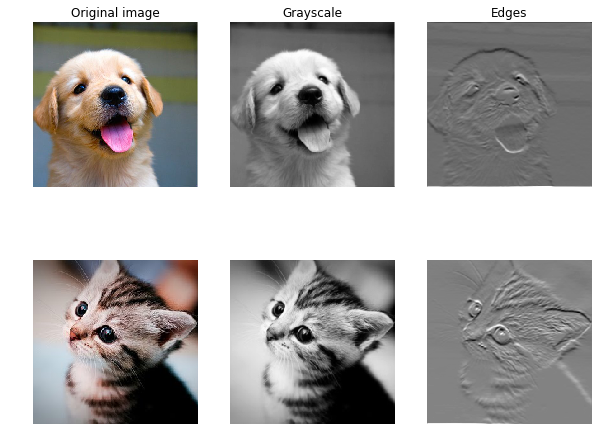

In [9]:
# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

**Summary**. To summarize, the Conv Layer:

1. Accepts a volume of size $W_1 \times H_1 \times D_1$
2. Requires four hyperparameters:
  - Number of filters $K$,
  - their spatial extent $F$,
  - the stride $S$,
  - the amount of zero padding $P$.
3. Produces a volume of size $W_2 \times H_2 \times D_2$ where:
  - $W_2=(W_1−F+2P)/S+1$
  - $H_2=(H_1−F+2P)/S+1$ (i.e. width and height are computed equally by symmetry)
  - $D_2=K$
4. With **parameter sharing**, it introduces $F\times F \times D1$ weights per filter, for a total of $F\times F \times D1 \times K$ weights and $K$ biases.
5. In the output volume, the $d$-th depth slice (of size $W_2×H_2$) is the result of performing a valid convolution of the $d$-th   filter over the input volume with a stride of $S$, and then offset by $d$-th bias.

# 3.3. Convolution: Naive backward pass

As shown in the summary, we can see that there are $W_2 \times H_2$ neurons with Depth $D_2$ in the Conv layer. The respective field of each neuron is $F\times F$. For (k, l) neuron, the corresponding respective files in the input is `[k*S:K*S+F,l*S:l*S+F]`

(1). **Gradeint of filters**

Because of the **parameters sharing**, a specific element in the filter is used by each neuron. According to the sliding filtering, for the [i,j] element of a filter, the neurons take pixels from `[:, i:i+W2*S:S, j:j+H2*S:S]` of the input. With the linearity of the filtering, the gradient of filters can be written as:
```python
# For dw: size (C, HH, WW)
dw = np.zeros((F, C, HH, WW))
for fprime in range(F):         # corresponding to the fprime-th filter
    for cprime in range(C):     # corresponding to the cprime-th channel of a specific channel
        for i in range(HH):     # corresponding to the i-th element of first dimension
            for j in range(WW): # corresponding to the j-th element of second dimension
            
                sub_xpad = x_pad[:, cprime, i:i+Hh*S:S, j:j+Hw*S:S]  
                
                dw[fprime, cprime, i, j] = np.sum(dout[:, fprime, :, :] * sub_xpad)
```

(2). **Gradient of biases**
Because one bias corresponds to one filter, so the calculation of gradients of biases is performed as 
```python
# For db:  size (F, )
db = np.zeros((F))
for fprime in range (F):
    db[fprime] = np.sum(dout[:, fprime, :, :])  # pay attention to the SUM operation
```

(3). **Gradient of input image**
For a [i,j] element of input, we need to determine which neuron takes it and then determine the corresponding weight
```python
dx = np.zeros((N, C, H, W))
# calculate dx use the linearity property of convolution operation.
# nprime, i, j is index for input
for nprime in range(N):      # corresponding to the nprime-th input
    for i in range(H):       # corresponding to the i-th element in first dimension
        for j in range(W):   # corresponding to the j-th element in second dimension
            # f, k, l is index for dout
            for f in range(F):          # corresponding to the f-th filter
                for k in range(Hh):     # corresponding to the k-th neuron in first dimension
                    for l in range(Hw): # corresponding to the l-th neuron in second dimension

                        mask1 = np.zeros_like(w[f, :, :, :])
                        mask2 = np.zeros_like(w[f, :, :, :])
                        # judge whether (i,j) element has contribution to the output of (k,l) neuron.
                        # the padded zeros are taken into account.
                        if (i + P - k * S) < HH and (i + P - k * S) >= 0:
                            mask1[:, i + P - k * S, :] = 1
                        if (j + P - l * S) < WW and (j + P - l * S) >= 0:
                            mask2[:, :, j + P - l * S] = 1

                        w_masked = np.sum(w[f, :, :, :] * mask1 * mask2, axis=(1, 2))

                        dx[nprime, :, i, j] += dout[nprime, f, k, l] * w_masked
```

In [10]:
from time import time 
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-9'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  9.20799168778e-09
dw error:  2.69180611651e-10
db error:  1.19290014236e-11


## 3.4. Max pooling: Naive forward

For the maxpooling, we need to know the pooling configuration, including pooling width, pooling height and stride.

**Summary**. the pooling layer:
1. Accepts a volume of size $W_1 \times H_1 \times D_1$
2. Requires two hyperparameters:
  - their spatial extent $F$,
  - the stride $S$, 
3. Produces a volume of size $W_2 \times H_2 \times D_2$ where:
  - $W_2 = (W_1 - F) /S + 1$
  - $H_2 = (H_1-F)/S+1$
  - $D_2=D_1$
4. Introduces zero parameters since it computes a fixed function of the input
5. Note that it is not common to use zero-padding for Pooling layers

```python
H1 = np.int((H - Hp) / S) + 1   # height of output
W1 = np.int((W - Wp) / S) + 1   # width of output 

out = np.zeros((N, C, H1, W1))
for n in range(N):
    for c in range(C):
        for k in range(H1):
            for l in range(W1):
                out[n, c, k, l] = np.max(x[n, c, k*S:k*S+Hp, l*S:l*S+Wp])
```

In [11]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


## 3.5. Max pooling: Naive backward

Like the derivation of CONV backward, we first extract the patch for each neuron and then determine the location of maximum of this patch, then driect pass the dout of this neuron back to dx.
```python
H1 = np.int((H - Hp) / S) + 1
W1 = np.int((W - Wp) / S) + 1

dx = np.zeros((N, C, H, W))
for nprime in range(N):
    for cprime in range(C):
        for k in range(H1):
            for l in range(W1):
                x_pooling = x[nprime, cprime, k*S:k*S+Hp, l*S:l*S+Wp]
                maxi = np.max(x_pooling)
                x_mask = x_pooling == maxi
                dx[nprime, cprime, k*S:k*S+Hp, l*S:l*S+Wp] += dout[nprime, cprime, k, l] * x_mask
```

In [12]:
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562825865e-12


## 4. Fast layers

### 4.1. Fast convolution layer
Making convolution and pooling layers fast can be challenging. The property of numpy is used.

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE**: The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

The basic trick is to directly manipulate the strides of the array.
Refer to [Efficient Numpy 2D array construction from 1D array
](https://stackoverflow.com/questions/4923617/efficient-numpy-2d-array-construction-from-1d-array).
If we generalize this to a "rolling window" along the last axis for an N-dimensional array, we get Erik Rigtorp's "rolling window" function:

In [13]:
def rolling_window(a, window):
    """
    Make an ndarray with a rolling window of the last dimension

    Parameters
    ----------
    a : array_like
       Array to add rolling window to
    window : int
       Size of rolling window

    Returns
    -------
    Array that is a view of the original array with a added dimension
    of size w.

    Examples
    --------
    >>> x=np.arange(10).reshape((2,5))
    >>> rolling_window(x, 3)
    array([[[0, 1, 2], [1, 2, 3], [2, 3, 4]],
          [[5, 6, 7], [6, 7, 8], [7, 8, 9]]])

    Calculate rolling mean of last dimension:
    >>> np.mean(rolling_window(x, 3), -1)
    array([[ 1.,  2.,  3.],
          [ 6.,  7.,  8.]])

    """
    if window < 1:
        raise ValueError("`window` must be at least 1.")
    if window > a.shape[-1]:
        raise ValueError("`window` is too long.")
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    print('The object shape is:', shape)
    strides = a.strides + (a.strides[-1],)
    print('The required strides is:', strides)
    return np.ascontiguousarray(np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides))

In [14]:
x=np.arange(10).reshape((2,5))
print('X.strides is: ', x.strides)
temp = rolling_window(x, 3)
print('temp.strides is: ', temp.strides)
print(temp)

X.strides is:  (20, 4)
The object shape is: (2, 3, 3)
The required strides is: (20, 4, 4)
temp.strides is:  (36, 12, 4)
[[[0 1 2]
  [1 2 3]
  [2 3 4]]

 [[5 6 7]
  [6 7 8]
  [7 8 9]]]


In this sense, we need to:
- define the shape of the output
- calculate the strides required for geting each dimension

![](im2col.png)

In the conv_forward_fast function, we do this by:
```python

H += 2 * pad                  # the height of padded input image
W += 2 * pad                  # the width of padded input image
# figure out output dimensions
out_h = np.int((H - HH) / stride) + 1
out_w = np.int((W - WW) / stride) + 1

# Perform an im2col operation by picking clever strides
shape = (C, HH, WW, N, out_h, out_w)  # output shape

strides = (H * W, W, 1, C * H * W, stride * W, stride) # strides should be made to get aforementioned shape 
strides = x.itemsize * np.array(strides) # 8 * array([H * W, W, 1, C * H * W, stride * W, stride])

x_stride = np.lib.stride_tricks.as_strided(x_padded, shape=shape, strides=strides)
x_cols = np.ascontiguousarray(x_stride)

x_cols.shape = (C * HH * WW, N * out_h * out_w)

# Now all out convolutions are a big matrix multiply
res = w.reshape(F, -1).dot(x_cols) + b.reshape(-1, 1)
```

In [15]:
from CS231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(10, 3, 31, 31)
w = np.random.randn(5, 3, 3, 3)
b = np.random.randn(5,)

conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
#print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print( 'Difference: ', rel_error(out_naive, out_fast))

Testing conv_forward_fast:
Naive: 0.062474s
Fast: 0.015626s
Difference:  4.85276577954e-13


As we have transformed x into columns, the backprojections are easy to implement:
```python
N, C, H, W = x.shape
F, _, HH, WW = w.shape
_, _, out_h, out_w = dout.shape

# Step 1: calculat the derivative corresponding to b
db = np.sum(dout, axis=(0, 2, 3))
# Step 2: calculate the derivative corresponding to w
dout_reshaped = dout.transpose(1, 0, 2, 3).reshape(F, -1)
dw = dout_reshaped.dot(x_cols.T).reshape(w.shape)

# Step 3: calculate the derivative corresponding to x
dx_cols = w.reshape(F, -1).T.dot(dout_reshaped)
dx_cols.shape = (C, HH, WW, N, out_h, out_w)
dx = col2im_6d_cython(dx_cols, N, C, H, W, HH, WW, pad, stride) # recover dx from dx_cols.
```

**Note**: col2im_6d_cython depends on a Cython extension, which can accelerate the process.

In [16]:
dout = np.random.randn(10, 5, 16, 16)
print('Testing conv_backward_fast:')
t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
print('Naive: %fs' % (t1 - t0))

dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()
print('Fast: %fs' % (t2 - t1))

#print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))  
print( 'dx difference: ', rel_error(dx_naive, dx_fast))
print( 'dw difference: ', rel_error(dw_naive, dw_fast))
print( 'db difference: ', rel_error(db_naive, db_fast))

Testing conv_backward_fast:
Naive: 188.404649s
Fast: 0.296908s
dx difference:  1.2387454523e-12
dw difference:  1.19073861439e-14
db difference:  2.96477692493e-15


### 4.2. Fast Max-pooling 

In [17]:
from CS231n.fast_layers import max_pool_forward_fast

x_shape = (40, 3, 40, 40)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

print('Testing maxpooling fast:')
t0 = time()
out_naive, _ = max_pool_forward_naive(x, pool_param)
t1 = time()
print('Naive: %fs' % (t1 - t0))

out_fast, _ = max_pool_forward_fast(x, pool_param)
t2 = time()
print('Fast: %fs' % (t2 - t1))

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_fast function:')
print('difference: ', rel_error(out_naive, out_fast))

Testing maxpooling fast:
Naive: 0.244640s
Fast: 0.001504s
Testing max_pool_forward_fast function:
difference:  0.0


In [18]:
from CS231n.fast_layers import max_pool_backward_fast

x = np.random.randn(80, 3, 40, 40)
dout = np.random.randn(80, 3, 20, 20)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = max_pool_forward_naive(x, pool_param)
dx_naive = max_pool_backward_naive(dout, cache)

out, cache = max_pool_forward_fast(x, pool_param)
dx_fast = max_pool_backward_fast(dout, cache)


# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_backward_fast function:')
print('difference: ', rel_error(dx_naive, dx_fast))

Testing max_pool_backward_fast function:
difference:  0.0


## 5. Convolutional "sandwich" layers 
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns.

### 5.1. Testing conv_relu_forward/backward

In [19]:
from CS231n.layer_utils import conv_relu_forward, conv_relu_backward

x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.0667238309e-08
dw error:  4.8789475058e-09
db error:  1.32428292824e-10


### 5.2. Testing conv_relu_pool_forward/backward

In [20]:
from CS231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3, )
dout = np.random.randn(2, 3, 8, 8)

conv_param = {'stride':1, 'pad':1}
pool_param = {'pool_height':2, 'pool_width':2, 'stride':2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  3.95827296902e-09
dw error:  2.90845713065e-09
db error:  1.26597372289e-11


## 6. Three-layer ConvNet

### 6.1. Sanity check loss

After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about $log(C)$ for C classes. When we add regularization this should go up.

First, we build a three-layer convolutional network with the following architecture:


<font color=#FF0000 >**conv -> relu -> 2x2 max pool -> affine -> relu -> affine -> softmax**</font>

Benefitted from the modular design, this architecture can be integrated very easily.

In [21]:
from CS231n.classifiers.cnn import *
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3025831604
Initial loss (with regularization):  2.5083792475


### 6.2. Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [22]:
num_inputs = 2
input_dim = (3, 10, 10)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, 
                          hidden_dim=7,    # Number of units to use in the fully-connected hidden layer
                          dtype=np.float64)

loss, grads = model.loss(X, y)

for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print("%s max relative error: %e" % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.897152e-03
W2 max relative error: 1.441214e-02
W3 max relative error: 1.151256e-04
b1 max relative error: 1.915139e-05
b2 max relative error: 2.567886e-01
b3 max relative error: 1.301638e-09


### 6.3. Overfit small data

A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

(Iteration "1" / "40") loss: "2.445862"
(Epoch "0" / "20") train acc: "0.230000"; val_acc: "0.162000"
(Iteration "2" / "40") loss: "2.709397"
(Epoch "1" / "20") train acc: "0.260000"; val_acc: "0.120000"
(Iteration "3" / "40") loss: "2.701953"
(Iteration "4" / "40") loss: "3.351648"
(Epoch "2" / "20") train acc: "0.230000"; val_acc: "0.126000"
(Iteration "5" / "40") loss: "3.237387"
(Iteration "6" / "40") loss: "2.529187"
(Epoch "3" / "20") train acc: "0.240000"; val_acc: "0.074000"
(Iteration "7" / "40") loss: "2.110152"
(Iteration "8" / "40") loss: "2.076383"
(Epoch "4" / "20") train acc: "0.310000"; val_acc: "0.173000"
(Iteration "9" / "40") loss: "1.940873"
(Iteration "10" / "40") loss: "1.685103"
(Epoch "5" / "20") train acc: "0.470000"; val_acc: "0.165000"
(Iteration "11" / "40") loss: "1.499624"
(Iteration "12" / "40") loss: "1.505082"
(Epoch "6" / "20") train acc: "0.630000"; val_acc: "0.196000"
(Iteration "13" / "40") loss: "1.104654"
(Iteration "14" / "40") loss: "1.152489"
(

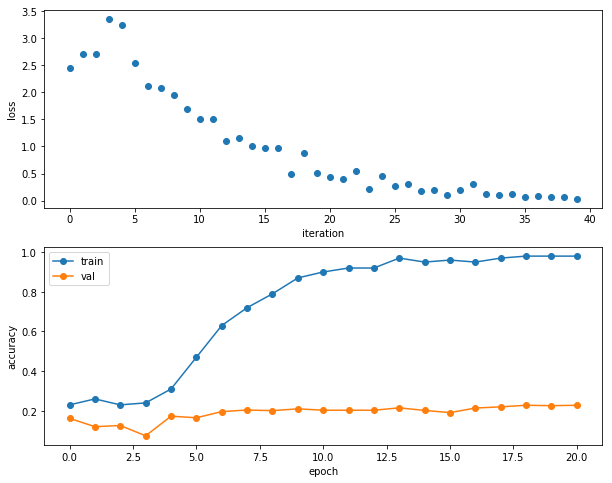

In [23]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='Adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### 6.4. Train the net

In [24]:
model = ThreeLayerConvNet(weight_scale=1e-3, hidden_dim=500, reg=1e-3)

solver =  Solver(model,data,
                num_epochs=1, batch_size=50,
                update_rule='Adam',
                optim_config={
                  'learning_rate':1e-3
                },
                verbose=True, print_every=40)

solver.train()

(Iteration "1" / "980") loss: "2.304527"
(Epoch "0" / "1") train acc: "0.101000"; val_acc: "0.119000"
(Iteration "41" / "980") loss: "1.832764"
(Iteration "81" / "980") loss: "1.640040"
(Iteration "121" / "980") loss: "1.883714"
(Iteration "161" / "980") loss: "1.821664"
(Iteration "201" / "980") loss: "2.050651"
(Iteration "241" / "980") loss: "1.748201"
(Iteration "281" / "980") loss: "1.404405"
(Iteration "321" / "980") loss: "1.858487"
(Iteration "361" / "980") loss: "2.063545"
(Iteration "401" / "980") loss: "1.711260"
(Iteration "441" / "980") loss: "1.516424"
(Iteration "481" / "980") loss: "1.435168"
(Iteration "521" / "980") loss: "1.776722"
(Iteration "561" / "980") loss: "1.539347"
(Iteration "601" / "980") loss: "1.479549"
(Iteration "641" / "980") loss: "1.770486"
(Iteration "681" / "980") loss: "1.544883"
(Iteration "721" / "980") loss: "1.687713"
(Iteration "761" / "980") loss: "1.685021"
(Iteration "801" / "980") loss: "1.583680"
(Iteration "841" / "980") loss: "1.41578

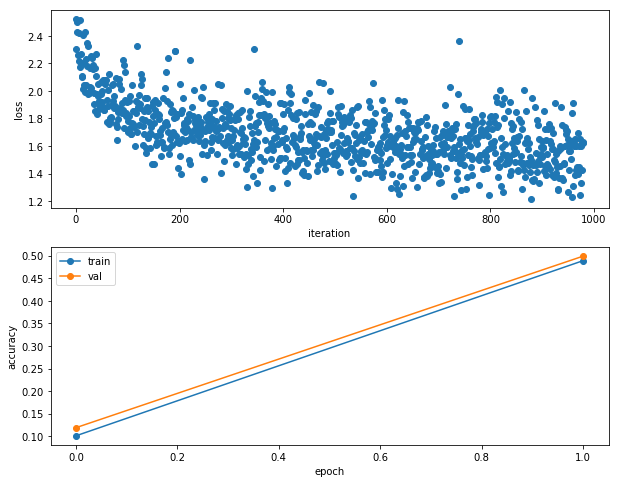

In [25]:
# plot the training history
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

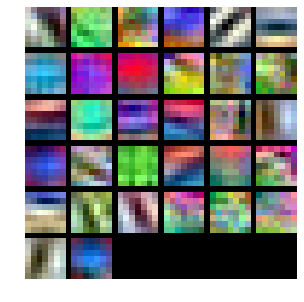

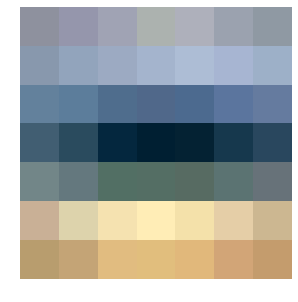

In [26]:
# visualize the weights of first conv layer
from CS231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

img = model.params['W1'].transpose(0, 2, 3, 1)[5]
low, high = np.min(img), np.max(img)
img = 255 * (img - low) / (high - low)
plt.imshow(img.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)

## 7. Spatial Batch Normalization

We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape (N, D) and produces outputs of shape (N, D), where we normalize across the minibatch dimension N. **For data coming from convolutional layers, batch normalization needs to accept inputs of shape (N, F, H, W) and produce outputs of shape (N, F, H, W)** where the N dimension gives the minibatch size and the (H, W) dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the **statistics of each feature channel to be relatively consistent both between different images and different locations within the same image**. Therefore spatial batch normalization computes a mean and variance for each of the F feature channels by computing statistics over both the minibatch dimension N and the spatial dimensions H and W.

For example, there are 6 feature of shape (100, 100), this corresponds to 6x100x100 neurons. As is shown  in BatchNormalization.ipynb, BN is implemented by each neuron, if we use the conventional BN developped for fully-connected networks, there will be 6x100x100 $\gamma$ and $\beta$. This number is enormous. Due to the **weights sharing** strategy in CNN, we can think that **statistics of each feature channel to be relatively consistent both between different images and different locations within the same image**. In this sense, we can treate a feature map as one neuron, so spatial batch normalization computes a mean and variance for each of the F feature channels by computing statistics over both the minibatch dimension N and the spatial dimensions H and W.

### 7.1 Spatial Batch Normalization: Forward 

In **keras**, the spatial BN is implemented as:
```python
input_shape = self.input_shape  

reduction_axes = list(range(len(input_shape)))  
del reduction_axes[self.axis]  # self.axis corresponds to the feature map number

broadcast_shape = [1] * len(input_shape)  
broadcast_shape[self.axis] = input_shape[self.axis]  

if train:  
    m = K.mean(X, axis=reduction_axes)  
    brodcast_m = K.reshape(m, broadcast_shape)  
    std = K.mean(K.square(X - brodcast_m) + self.epsilon, axis=reduction_axes)  
    std = K.sqrt(std)  
    brodcast_std = K.reshape(std, broadcast_shape)  
    
    mean_update = self.momentum * self.running_mean + (1-self.momentum) * m  
    std_update = self.momentum * self.running_std + (1-self.momentum) * std  
    
    self.updates = [(self.running_mean, mean_update), (self.running_std, std_update)]  
    X_normed = (X - brodcast_m) / (brodcast_std + self.epsilon)  
    
else:  
    brodcast_m = K.reshape(self.running_mean, broadcast_shape)  
    brodcast_std = K.reshape(self.running_std, broadcast_shape)  
    X_normed = ((X - brodcast_m) /  
             (brodcast_std + self.epsilon))  
             
out = K.reshape(self.gamma, broadcast_shape) * X_normed + K.reshape(self.beta, broadcast_shape) 
```

In *layers.py*, we implement spatial_batchnorm_forward(x, gamma, beta, bn_param):  
```python
N, F, H, W = x.shape
mode = bn_param['mode']
eps =  bn_param.get('eps', 1e-5)
momentum = bn_param.get('momentum', 0.9)

# Note: the dimension of running_mean is (F, ) here
running_mean = bn_param.get('running_mean', np.zeros(F, dtype = x.dtype)) 
running_var = bn_param.get('running_var', np.zeros(F, dtype = x.dtype))
if mode == 'train':
    # Step 1: calculate the average for each channel
    mu = (1./(N*H*W) * np.sum(x, axis=(0, 2, 3))).reshape(1, F, 1, 1)
    var = (1./(N*H*W) * np.sum((x-mu)**2, axis=(0, 2, 3))).reshape(1, F, 1, 1)

    # step 2: the key step of batch nomarlization
    xhat = (x - mu) / (np.sqrt(eps+var))

    out = gamma.reshape(1, F, 1, 1) * xhat + beta.reshape(1, F, 1, 1)

    # Step 3: mean and variance update
    running_mean = momentum * running_mean + (1-momentum) * np.squeeze(mu)
    running_var = momentum * running_var +(1-momentum)*np.squeeze(var)

    cache = (mu, var, x, xhat, gamma, beta, bn_param)

    # store the updated running means and variance back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

elif mode == 'test':
    mu = running_mean.reshape(1, F, 1, 1)
    var = running_var.reshape(1, F, 1, 1)

    xhat = (x - mu) /(np.sqrt(eps+var))
    out = gamma.reshape(1, F, 1, 1) * xhat + beta.reshape(1, F, 1, 1)
    cache = (mu, var, x, xhat, gamma, beta, bn_param)
else:
    raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

return out, cache
```

In [27]:
# Check the training-time forward pass by checking means and variances 
# of features both before and after spatial batch normalization
N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization')
print(' Shape: ', x.shape)
print(' Means: ', x.mean(axis=(0, 2, 3)))
print(' Stds:', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization
 Shape:  (2, 3, 4, 5)
 Means:  [ 11.75581248  10.09162256  10.54328796]
 Stds: [ 3.21627129  3.55401728  4.74686817]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [  1.63757896e-16  -2.22044605e-16  -3.45556916e-16]
  Stds:  [ 0.99999952  0.9999996   0.99999978]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.99999855  3.99999842  4.99999889]


In [28]:
# Check the test-time forward pass by running the training-time forward
# pass many times to warm up the running averages, and then checking the means
# and variances of activations after a test-time forward pass.

N, C, H, W = 10, 4, 11, 12
bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)

bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [ 0.04071954  0.02809192  0.00357135  0.0391682 ]
  stds:  [ 0.99817552  0.98330737  1.00383409  0.98455167]


### 7.2. Spatial Batch Normalization: Backward

The gradient derivation of spatial BN is the same as that of BN for fully-connected layers. So the backward pass of spatial BN is:
```python
dx, dgamma, dbeta = None, None, None
mu, var, x, xhat, gamma, beta, bn_param = cache
N, C, H, W = x.shape
mode = bn_param['mode']
eps = bn_param.get('eps', 1e-5)

gamma = gamma.reshape(1, C, 1, 1)
beta = beta.reshape(1, C, 1, 1)

dbeta = np.sum(dout, axis=(0, 2, 3))
dgamma = np.sum(dout*xhat, axis=(0, 2, 3))

Nt = N*H*W 
dx = (1./Nt) * gamma * (var+eps)**(-1./2) *(Nt*dout
       -np.sum(dout, axis=(0, 2, 3)).reshape(1, C, 1, 1)
       -(x-mu) * (var+eps)**(-1.0)*np.sum(dout*(x-mu), axis=(0, 2, 3)).reshape(1, C, 1, 1))

```

In [29]:
# spatial batchnormlization: backward
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.54629574883e-08
dgamma error:  6.08312167045e-13
dbeta error:  1.74179714231e-12


## 8. Experimets with CNN

Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet.

### 8.1. Base Case

In [30]:
# A three NN with three layers: 
# conv - relu - 2x2 max pool - affine - relu - affine - softmax
# Note: the default parameters are:
# def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7, hidden_dim=100,
#                 num_classes=10, weight_scale=1e-3, reg=0.0, dtype=np.float32, use_batchnorm=False):
        
model_base = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver_base = Solver(model_base, data,
                     num_epochs=1, batch_size=50,
                     update_rule='Adam',
                     optim_config={
                       'learning_rate': 1e-3,
                      },
                      verbose=True, print_every=20)
solver_base.train()

(Iteration "1" / "980") loss: "2.304475"
(Epoch "0" / "1") train acc: "0.107000"; val_acc: "0.079000"
(Iteration "21" / "980") loss: "2.166524"
(Iteration "41" / "980") loss: "2.042964"
(Iteration "61" / "980") loss: "1.825444"
(Iteration "81" / "980") loss: "1.830471"
(Iteration "101" / "980") loss: "1.697164"
(Iteration "121" / "980") loss: "1.754631"
(Iteration "141" / "980") loss: "1.883244"
(Iteration "161" / "980") loss: "1.673306"
(Iteration "181" / "980") loss: "1.481869"
(Iteration "201" / "980") loss: "1.935851"
(Iteration "221" / "980") loss: "1.804052"
(Iteration "241" / "980") loss: "1.848174"
(Iteration "261" / "980") loss: "1.600790"
(Iteration "281" / "980") loss: "2.156795"
(Iteration "301" / "980") loss: "1.577374"
(Iteration "321" / "980") loss: "1.561788"
(Iteration "341" / "980") loss: "1.920985"
(Iteration "361" / "980") loss: "1.681285"
(Iteration "381" / "980") loss: "1.578039"
(Iteration "401" / "980") loss: "1.736013"
(Iteration "421" / "980") loss: "1.666385"

### 8.2. Decrease filter size

In [31]:
# Decrease the size of the filter from 7 to 3
model_1 = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, filter_size = 3)

solver_1 = Solver(model_1, data,
                 num_epochs=1, batch_size=50,
                 update_rule='Adam',
                 optim_config={
                  'learning_rate': 1e-3,
                 },
                verbose=True, print_every=20)
solver_1.train()

(Iteration "1" / "980") loss: "2.304693"
(Epoch "0" / "1") train acc: "0.123000"; val_acc: "0.130000"
(Iteration "21" / "980") loss: "1.994523"
(Iteration "41" / "980") loss: "1.953571"
(Iteration "61" / "980") loss: "1.843424"
(Iteration "81" / "980") loss: "1.931315"
(Iteration "101" / "980") loss: "1.857822"
(Iteration "121" / "980") loss: "1.657597"
(Iteration "141" / "980") loss: "1.714810"
(Iteration "161" / "980") loss: "1.794186"
(Iteration "181" / "980") loss: "1.508273"
(Iteration "201" / "980") loss: "1.741055"
(Iteration "221" / "980") loss: "1.480401"
(Iteration "241" / "980") loss: "1.779256"
(Iteration "261" / "980") loss: "1.683256"
(Iteration "281" / "980") loss: "1.869085"
(Iteration "301" / "980") loss: "1.802362"
(Iteration "321" / "980") loss: "1.391688"
(Iteration "341" / "980") loss: "1.565423"
(Iteration "361" / "980") loss: "1.333190"
(Iteration "381" / "980") loss: "1.351264"
(Iteration "401" / "980") loss: "1.578787"
(Iteration "421" / "980") loss: "1.535431"

In [45]:
import seaborn as sns
def plot_loss(solvers):
    fig = plt.figure(figsize = (20,10))
    ax = plt.subplot(111)
    for key,solver in solvers.items():
        ax.plot(solver.loss_history, label =key)
        
    ax.legend(fontsize = 24)
    ax.tick_params(labelsize = 24)

def plot_accuracy(solvers):
    ax1 = plt.subplot(2, 1, 1)
    for key, solver in solvers.items():
        ax1.plot(solver.train_acc_history,label =key)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    ax2 = plt.subplot(2, 1, 2)
    for key, solver in solvers.items():
        ax2.plot(solver.val_acc_history,label =key)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

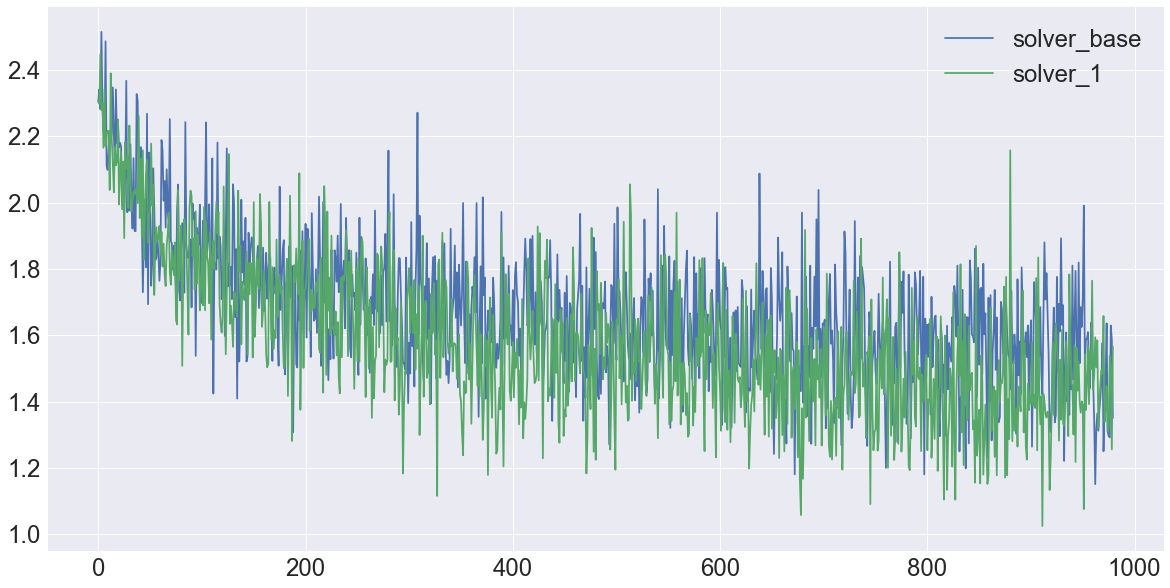

In [35]:
solvers = {'solver_base':solver_base,
           'solver_1':solver_1}
plot_loss(solvers)

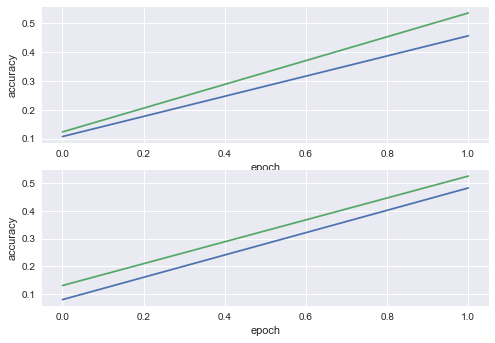

In [46]:
 plot_accuracy(solvers)

### 8.3. Experiment with batchnorm
#### 8.3.1. Testing conv_norm_relu_forward

In [ ]:
from CS231n.layer_utils import conv_norm_relu_forward, conv_norm_relu_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
gamma = np.ones(3)
beta = np.ones(3)
bn_param = {'mode': 'train',
            'running_mean': np.zeros(C),
            'running_var': np.zeros(C)}

dout = np.random.randn(2, 3, 16, 16)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)

dx, dw, db, dgamma, dbeta = conv_norm_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], b, dout)
dgamma_num = eval_numerical_gradient_array(lambda gamma:conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], gamma, dout)
dbeta_num = eval_numerical_gradient_array(lambda beta:conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], beta, dout)


print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))
print('dbeta error: ', rel_error(dbeta_num, dbeta))
print('dgamma error: ', rel_error(dgamma_num, dgamma))

#### 8.3.2 Testing conv_norm_relu_pool_forward

In [ ]:
from CS231n.layer_utils import conv_norm_relu_pool_forward, conv_norm_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
gamma = np.ones(3)
beta = np.ones(3)
bn_param = {'mode': 'train',
            'running_mean': np.zeros(C),
            'running_var': np.zeros(C)}

dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)
dx, dw, db, dgamma, dbeta = conv_norm_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], b, dout)
dgamma_num = eval_numerical_gradient_array(lambda gamma:conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], gamma, dout)
dbeta_num = eval_numerical_gradient_array(lambda beta:conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], beta, dout)


print( 'Testing conv_norm_relu_pool_forward')
print( 'dx error: ', rel_error(dx_num, dx))
print( 'dw error: ', rel_error(dw_num, dw))
print( 'db error: ', rel_error(db_num, db))
print( 'dbeta error: ', rel_error(dbeta_num, dbeta))
print( 'dgamma error: ', rel_error(dgamma_num, dgamma))

In [ ]:
model = ThreeLayerConvNet(use_batchnorm = True)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print( 'Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print( 'Initial loss (with regularization): ', loss)

In [ ]:
num_inputs = 2
input_dim = (3, 10, 10)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64,use_batchnorm = True)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print( '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

**Overfit small data**

In [ ]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2,use_batchnorm = True)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='Adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### 8.4.  CNN with BN

In [ ]:
# Incease the number of filters from 32 to 64
model_2 = ThreeLayerConvNet(weight_scale=0.001, num_filters = 64,
                            hidden_dim=500, reg=0.001, filter_size = 3,use_batchnorm=True)

solver_2 = Solver(model_2, data,
                num_epochs=1, batch_size=50,
                update_rule='Adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=40)
solver_2.train()

In [ ]:
solvers = {'solver_2':solver_2,
           'solver_1':solver_1,
           'solver_base':solver_base}
plot_loss(solvers)

In [ ]:
model_3 = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, filter_size = 3,use_batchnorm=True)

solver_3 = Solver(model_3, data,
                  num_epochs=10, batch_size=50,
                  update_rule='Adam',
                  optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver_3.train()

In [ ]:
solvers = {'solver_3':solver_3}
plot_loss(solvers)